In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from requests import get

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import spacy
nlp = spacy.load('en_core_web_sm')

from PIL import Image
from io import BytesIO

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings

warnings.simplefilter(action = "ignore", category = FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
episodes = pd.read_csv("../input/south-park-scripts-dataset/SouthPark_Episodes.csv")
display(episodes.head())
print(episodes.shape)

,Title,Air Date,Code,#,Description,Season,Episode
0,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1
1,Weight Gain 4000,"August 20, 1997",102,2,When Cartman's environmental essay wins a nati...,1,2
2,Volcano,"August 27, 1997",103,3,A weekend trip to experience the finer points ...,1,3
3,Big Gay Al's Big Gay Boat Ride,"September 3, 1997",104,4,"When Stan discovers his new dog Sparky is gay,...",1,4
4,An Elephant Makes Love to a Pig,"September 10, 1997",105,5,"Kyle's mom won't let him keep his new pet, an ...",1,5


(309, 7)


In [3]:
lines = pd.read_csv("../input/south-park-scripts-dataset/SouthPark_Lines.csv")
display(lines.head())
print(lines.shape)

,Title,Character,Line
0,Cartman Gets an Anal Probe,Scene Description,At the bus stop.
1,Cartman Gets an Anal Probe,The Boys,"School days, school days, teacher's golden ru..."
2,Cartman Gets an Anal Probe,Kyle Broflovski,"Ah, damn it! My little brother's trying to fol..."
3,Cartman Gets an Anal Probe,Ike Broflovski,Eat banana.
4,Cartman Gets an Anal Probe,Kyle,"Ike, you can't come to school with me. [Ike Ch..."


(95320, 3)


In [4]:
title_episodelist = episodes.Title.tolist()
title_lineslist = lines.Title.tolist()

[x for x in title_episodelist if x not in title_lineslist]

['Imaginationland Episode I', '#REHASH', '#HappyHolograms', 'Shots!!!']

In [5]:
rename_titles = {"Imaginationland": "Imaginationland Episode I",
                 "REHASH": "#REHASH",
                 "HappyHolograms": "#HappyHolograms",
                 "Shots": "Shots!!!"}

lines["Title"].replace(rename_titles, inplace = True)

In [6]:
df = episodes.merge(lines, on = "Title")
df

,Title,Air Date,Code,#,Description,Season,Episode,Character,Line
0,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Scene Description,At the bus stop.
1,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,The Boys,"School days, school days, teacher's golden ru..."
2,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Kyle Broflovski,"Ah, damn it! My little brother's trying to fol..."
3,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Ike Broflovski,Eat banana.
4,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Kyle,"Ike, you can't come to school with me. [Ike Ch..."
...,...,...,...,...,...,...,...,...,...
95315,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Cartman,[turns to face Clyde] Yeah?
95316,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Clyde,[standing with Jimmy and an unnamed Hispanic k...
95317,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Cartman,[he takes off his mask] Casa Bonita?! Hell yea...
95318,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Scene Description,Fourth grade classroom. Mr. Garrison opens the...


In [7]:
df = df[df["Line"].notnull()]

In [8]:
df["Act"] = df.Line.apply(lambda x: re.findall(r"\[.*?]", x) if "[" in x else "None")
df["Act"] = df["Act"].astype(str)
df["Act"] = df["Act"].str.replace("[", "").str.replace("]", "", regex = True)

In [9]:
df["Line2"] = df["Line"].str.replace(r"\[.*?]", "", regex = True)

df

,Title,Air Date,Code,#,Description,Season,Episode,Character,Line,Act,Line2
0,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Scene Description,At the bus stop.,None,At the bus stop.
1,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,The Boys,"School days, school days, teacher's golden ru...",None,"School days, school days, teacher's golden ru..."
2,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Kyle Broflovski,"Ah, damn it! My little brother's trying to fol...",None,"Ah, damn it! My little brother's trying to fol..."
3,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Ike Broflovski,Eat banana.,None,Eat banana.
4,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus,...",1,1,Kyle,"Ike, you can't come to school with me. [Ike Ch...",'Ike Chortles.',"Ike, you can't come to school with me."
...,...,...,...,...,...,...,...,...,...,...,...
95315,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Cartman,[turns to face Clyde] Yeah?,'turns to face Clyde',Yeah?
95316,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Clyde,[standing with Jimmy and an unnamed Hispanic k...,'standing with Jimmy and an unnamed Hispanic kid',"Dude, they're reopening Casa Bonita this week..."
95317,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Cartman,[he takes off his mask] Casa Bonita?! Hell yea...,"'he takes off his mask', 'his face falls', 'he...","Casa Bonita?! Hell yeah, I'll come! Oh, wait..."
95318,South ParQ Vaccination Special,"March 10, 2021",2402,309,The citizens of South ParQ are clamoring for t...,24,2,Scene Description,Fourth grade classroom. Mr. Garrison opens the...,None,Fourth grade classroom. Mr. Garrison opens the...


In [10]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"wanna": "want to",
"gonna": "going to",
"gotta": "have got to"
}

In [11]:
all_stopwords = nlp.Defaults.stop_words

def tokenizer(text):
    
    text = text.replace("in'", "ing")
    text = text.replace("m'kay", "mkay")
    tokens = text.split()
    tokens = [re.sub(token, contractions[token], token) if token in contractions.keys() else token for token in tokens]
    tokens = [token.strip(string.punctuation) for token in tokens]    
    tokens = [token.lower() for token in tokens]    
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [token for token in tokens if token not in all_stopwords]

#     n = lambda pos: pos[:2].startswith("N")
#     tokens = [word for (word, pos) in nltk.pos_tag(tokens) if n(pos)] 
    
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token, "v")  if token != "butters" else "butters" for token in tokens]
    lemmas = [lemmatizer.lemmatize(token)  if token != "butters" else "butters" for token in lemmas]
    lemmas = [lemma for lemma in lemmas if lemma not in ["think", "know", "come", "want", "look", "right", "try",
                                                         "need", "say", "yes", "good", "okay", "people", "time", "tell",
                                                         "talk", "stop", "thing", "mean", "maybe", "let"]]  
    
    lemmas = [lemma.replace(lemma, "guys") if lemma == "guy" else lemma for lemma in lemmas]    
    return " ".join(lemmas)

df["Lines_Final"] = df["Line2"].apply(tokenizer)

In [12]:
df.iloc[:, -4:]

,Line,Act,Line2,Lines_Final
0,At the bus stop.,None,At the bus stop.,bus
1,"School days, school days, teacher's golden ru...",None,"School days, school days, teacher's golden ru...",school day school day golden ru
2,"Ah, damn it! My little brother's trying to fol...",None,"Ah, damn it! My little brother's trying to fol...",ah damn little follow school
3,Eat banana.,None,Eat banana.,eat banana
4,"Ike, you can't come to school with me. [Ike Ch...",'Ike Chortles.',"Ike, you can't come to school with me.",ike school
...,...,...,...,...
95315,[turns to face Clyde] Yeah?,'turns to face Clyde',Yeah?,yeah
95316,[standing with Jimmy and an unnamed Hispanic k...,'standing with Jimmy and an unnamed Hispanic kid',"Dude, they're reopening Casa Bonita this week...",dude reopen casa bonita weekend
95317,[he takes off his mask] Casa Bonita?! Hell yea...,"'he takes off his mask', 'his face falls', 'he...","Casa Bonita?! Hell yeah, I'll come! Oh, wait...",casa bonita hell yeah oh wait fuck kenny weeke...
95318,Fourth grade classroom. Mr. Garrison opens the...,None,Fourth grade classroom. Mr. Garrison opens the...,fourth grade classroom mr garrison open door w...


In [13]:
img_dict = {"Cartman": "https://i.imgur.com/DtPNaXk.png",
            "Kyle": "https://i.imgur.com/5vBEIri.png",
            "Kenny": "https://i.imgur.com/IbHV3iA.png",
            "Stan": "https://i.imgur.com/Pl94sMm.png",
            "Randy": "https://i.imgur.com/EgMCfsr.png",
            "Mr. Mackey": "https://i.imgur.com/bdJE2SB.png",
            "Butters": "https://i.imgur.com/EQAUV7i.png"}

In [14]:
def plot_wordcloud(character, max_words = 500):
    
    character_df = df[df.Character == character]
    txt = " ".join(character_df["Lines_Final"].values)    
    
    im = Image.open(BytesIO(get(img_dict[character]).content))
    mask = np.array(im)
    colors = ImageColorGenerator(mask)
    
    fig, ax = plt.subplots(figsize = (15, 15))
    
    stopwords = set(STOPWORDS)
    
    wc = WordCloud(background_color = "black", 
                   max_words = max_words, 
                   mask = mask, # shape
                   stopwords = stopwords, 
                   width = 1000, 
                   height = 1000,
                   color_func = colors,
                   collocations = True, #bigrams
                   contour_color = 'white',
                   contour_width = 1,
                   normalize_plurals = False, #For Butters
                   min_word_length = 3,
                   random_state = 42).generate(txt)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(character + ".png")
    plt.show()
    

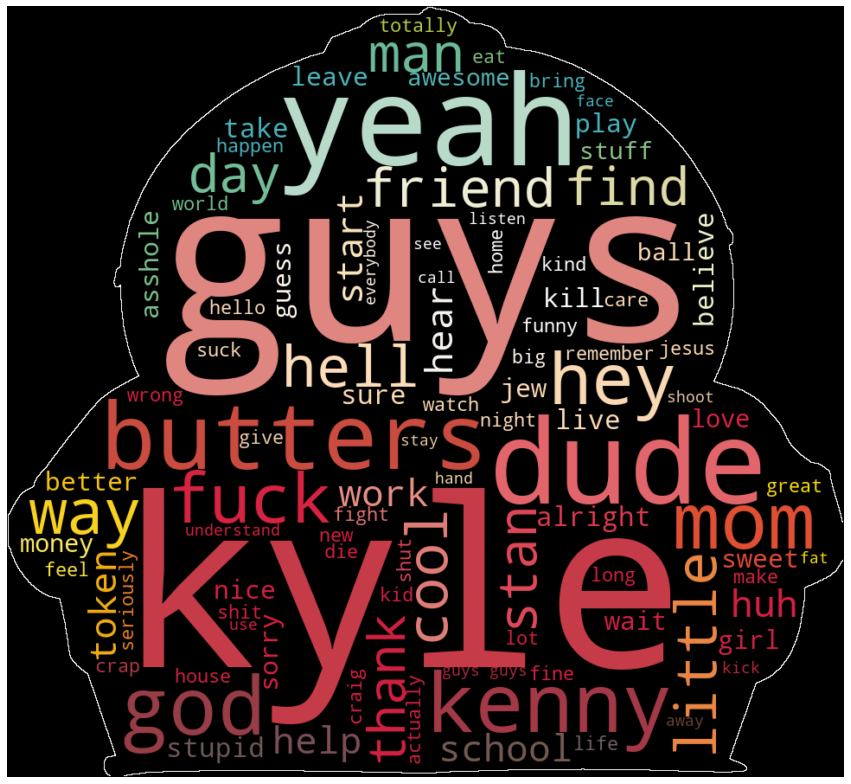

In [15]:
plot_wordcloud("Cartman", 100)

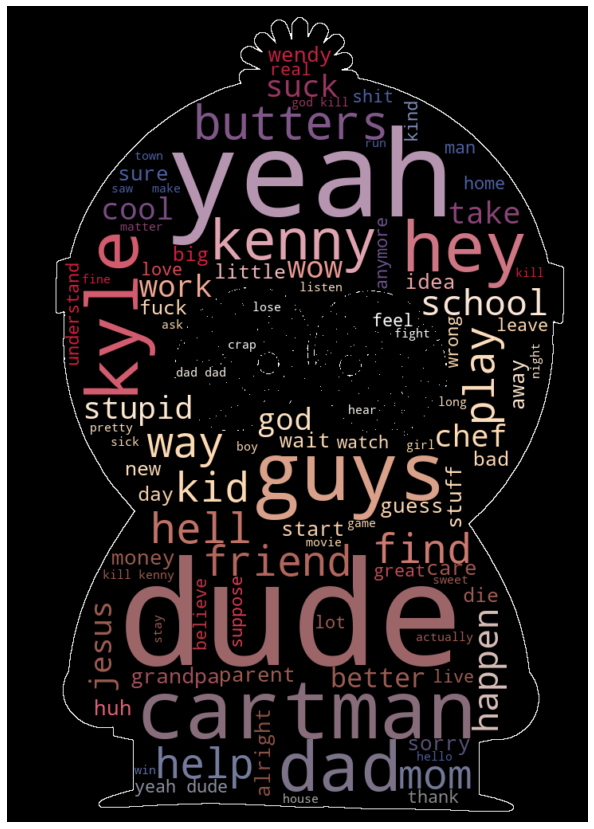

In [16]:
plot_wordcloud("Stan", 100)

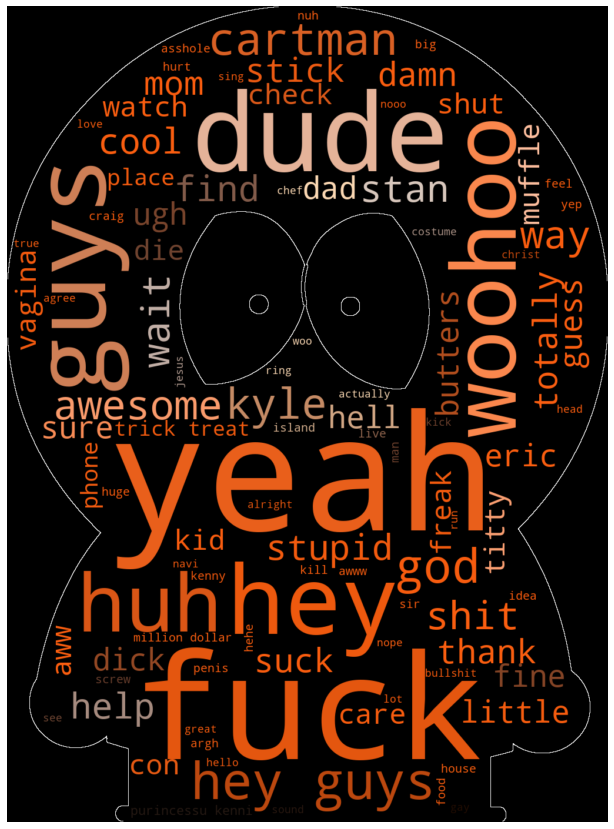

In [17]:
plot_wordcloud("Kenny", 100)

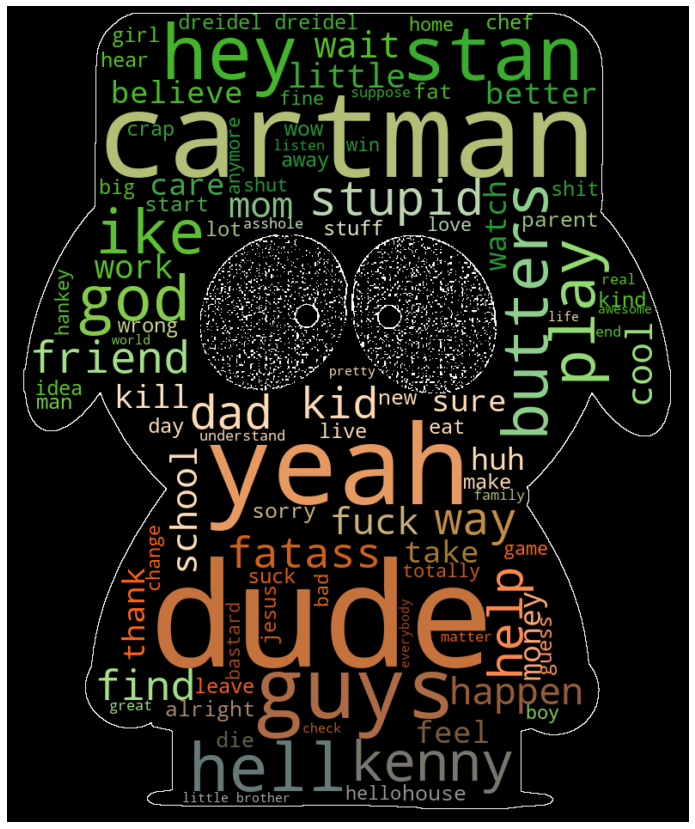

In [18]:
plot_wordcloud("Kyle", 100)

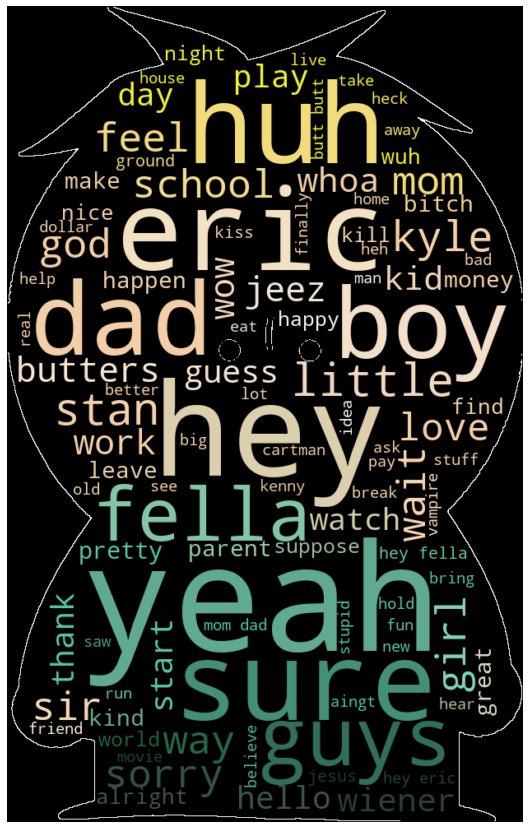

In [19]:
plot_wordcloud("Butters", 100)

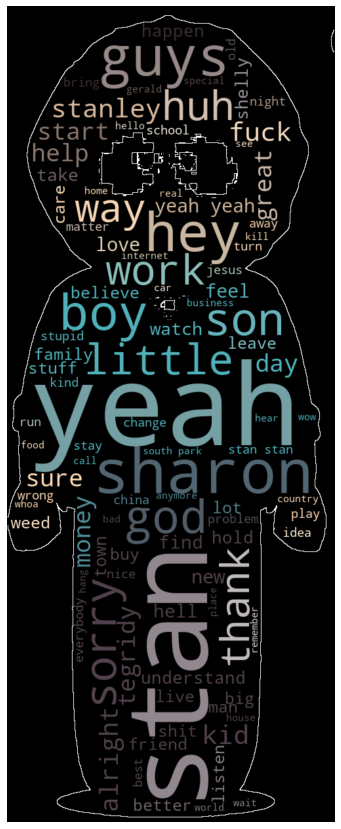

In [20]:
plot_wordcloud("Randy", 100)

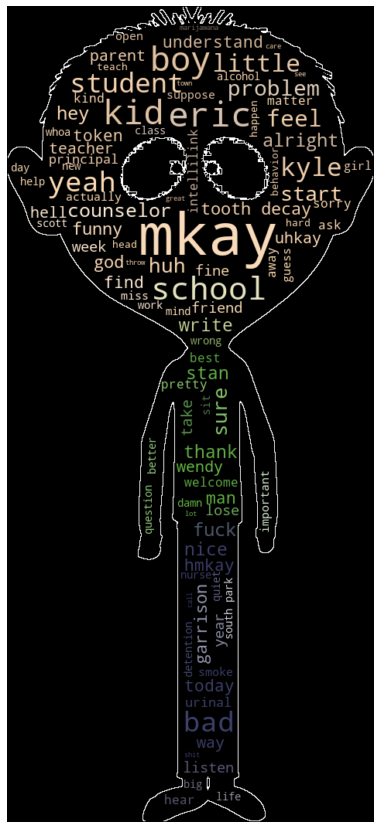

In [21]:
plot_wordcloud("Mr. Mackey", 100)